<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-fitting-L+C//R" data-toc-modified-id="Example-fitting-L+C//R-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example fitting L+C//R</a></span></li><li><span><a href="#Example-fit-inductors-Rdc+L//Rproximity//Cp" data-toc-modified-id="Example-fit-inductors-Rdc+L//Rproximity//Cp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example fit inductors Rdc+L//Rproximity//Cp</a></span></li></ul></div>

In [10]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np

import pandas as pd
import zfit_modelcore_cli as zfitcli
from zfit_plot import LogLogPlotDualAxisPlotly

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The following code is used adapting the python script Zfit2.0, tuning it to be possible to call it from CLI (command line interface) and from python notebook to be launched also online platform. the following code line permit to run the original code available at https://exality.com/fitting-equivalent-circuits-to-impedance-data/

In [52]:
# !python Zfit.pyw

Traceback (most recent call last):
  File "Zfit.pyw", line 13, in <module>
    from PyQt5 import sip
ModuleNotFoundError: No module named 'PyQt5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "Zfit.pyw", line 15, in <module>
    import sip
ModuleNotFoundError: No module named 'sip'


# Example fitting L+C//R
this example is useful in power electronic because is the typical output stage for a buck DC/DC stage. Measuring it between the swithing node and GND, then they can be compare with the theoretical values and verify if there are discrepancies due to manufacturing.

In [12]:
# Test case
# DESCRIPTION: load example Zfit
# EXPECTED RESULT: fitting correct in plotly
filename_choke=r"./TestDataFiles/Sample ls(cpr).csv"
df_LCR = pd.read_csv(filename_choke)
#df_LCR.columns

In [13]:
range = zfitcli.Range()
ya = zfitcli.YAxes(2)

range.xa['Hz'] = df_LCR['FREQUENCY [Hz]']
ya.inputData[0] = df_LCR['MAG [Ω]']
ya.inputData[1] = df_LCR['PHASE [deg]']

my_model = zfitcli.DoModel()
fit_model = zfitcli.import_module("Models." + "ls(cpr)")
my_model.do_model_cli(range=range, ya=ya, model=fit_model)

Ls, 7.676574111484213e-08
Cp, 9.744783995233943e-10
Rp, 194.79817132664598
Number of function calls: 35


In [14]:
newplot=LogLogPlotDualAxisPlotly()
newplot.add_trace(f=df_LCR['FREQUENCY [Hz]'], 
                  zabs=df_LCR['MAG [Ω]'], zdeg=df_LCR['PHASE [deg]'], 
                  label="Sample ls(cpr)")
newplot.add_trace(f=df_LCR['FREQUENCY [Hz]'], 
                  zabs=my_model.ya.modeledData[0], zdeg=my_model.ya.modeledData[1], 
                  label="FIT Sample ls(cpr)")
newplot.show()

# Example fit inductors Rdc+L//Rproximity//Cp
This is the typical fitting necessary with any power inductor. the simplest model used by many manufacturer to take in cosideration the increase of the losses with the frequency is 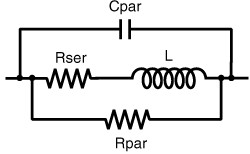

The 4 components have different purpose:

1. RDC fits the DC losses, this can be measured to with a normal 4W method or letting flow some DC current and measuring the voltage across the choke

2. Rproximity is a resistance placed in the electrical model in parallel to the inductance to model the AC losses due to proximity effect, this is because the losses raise with $f^2$

3. L is the inductance measured at low frequency (this value reduce if the frequency increases due to the eddy currents)

4. C is the equivalent total capacitance seen at the terminal (this include intra-winding and terminal capacitance)

If we extract the real part and the imaginary part of the complex impedance we can see that look like the following:

| | | |
|-|-|-|
|<img src="./img/math.png" alt="Re{Z} and Im{Z} equation" style="width: 500px;"/> |<img src="./img/real_imag.png" alt="Re{Z} and Im{Z} equation" style="width: 500px;"/> |

the imaginary part (what normally in attributed just to the inductance) drop with the frequency, and the real part rise with $f^2$. It's also worth to mention that if we set $Rp=0$, the model comes back to the simple $RL$ series (the simples inductor model possible)

## Inverter inductor fitting

In the next section, we will fit the LCR measurements from 3 different inverter inductors, produced with different techniques:
1. the one on the left is produced by the company Sirio SRL http://www.sirio-ic.com/index.php/en/
2. the one in the center is winding by my collegueas at NTBees
3. the one on the right is produced by Kasche Components https://kaschke.de/

<img src="./img/sirio.png" alt="NTB inductors set" style="width: 800px;"/>

### Sirio inductor fitting
in the next section we will fit the measurement of a Sirio inductor, used for a 3kW solar inverter.

In [63]:
# Test case
# DESCRIPTION: load coilcraft inductors and calc loss factor at different frequencies
# EXPECTED RESULT: new excel file with the same db and loss factor

filename_choke_sirio=r"./TestDataFiles/Inductor2.xls"
sheetname_choke_sirio="sirio"

# df_sirio = pd.read_excel(io=filename_choke, sheet_name=sheetname_choke_sirio)
df_sirio = pd.read_excel(io=filename_choke_sirio, sheet_name=sheetname_choke_sirio)

#R+j*X
f = df_sirio['Frequency (Hz)']
L = df_sirio['Inductance (H)']   
R = df_sirio['Resistance (O)']

# we calc complex impedance abs(Z)*exp(j*deg)
Zabs_sirio = np.abs(R+1j*2*np.pi*f*L)
Zdeg_sirio = np.angle(R+1j*2*np.pi*f*L)

In [147]:
range.xa['Hz'] = f
ya.inputData[0] = Zabs_sirio
ya.inputData[1] = Zdeg_sirio

my_model = zfitcli.DoModel()
#fit_model = zfitcli.import_module("Models." + "rpcpl")
fit_model = zfitcli.import_module("Models." + "rs(rpcpl)")
#fit_model = zfitcli.import_module("Models." + "rpcp(lsr_skin)")
#fit_model = zfitcli.import_module("Models." + "cpl_f")

# do_model_cli(self, range, ya, model, method_nr=0, do_norm_denorm=True):
my_model.do_model_cli(range=range, ya=ya, model=fit_model, method_nr=1)


Rs, 3.3318083289622025
C, 1.8087421265968284e-11
L, 0.0001188294931562211
Rp, 1110.6454931752314
Number of function calls: 14
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 14
    # data points      = 1602
    # variables        = 4
    chi-square         = 223.848049
    reduced chi-square = 0.14008013
    Akaike info crit   = -3144.80114
    Bayesian info crit = -3123.28511
[[Variables]]
    Rs:  0.10536103 +/- 0.00806683 (7.66%) (init = 0.03162278)
    C:   0.01476832 +/- 0.00151856 (10.28%) (init = 0.008164966)
    L:   97.0238749 +/- 3.82957355 (3.95%) (init = 122.4745)
    Rp:  35.1216943 +/- 2.31389618 (6.59%) (init = 31.62278)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, L) = -0.170


In [119]:
# compare the real parts of the impedance
# the measured one
# the real measurements from sirio inductor
Z=Zabs_sirio*np.exp(1j*Zdeg_sirio)
ReZ_sirio=np.real(Z)
newplot=LogLogPlotDualAxisPlotly()
newplot.add_trace(f=f, zabs=ReZ_sirio, zdeg=None, label="meas_SirioInductor")

# the fitted ones
params={"Rldc":0.01, "L":4e-5, "C":1e-10, "sf":1e-6}
# params={"Rldc":1e-2, "L":0.00015606072332020876, "C":2.5235270544381366e-11, "sf":1e-6}
fit_model = zfitcli.import_module("Models." + "cpl_f")
ReZ_fit = np.real(fit_model.model(w=2*np.pi*f, params=params))
newplot.add_trace(f=f, zabs=ReZ_fit, zdeg=None, label="fit_cpl_f_SirioInductor")

# the fitted ones
params={"Rs":16.6434734, "L":4e-5, "C":1e-10, "sf":1e-6}
# params={"Rldc":1e-2, "L":0.00015606072332020876, "C":2.5235270544381366e-11, "sf":1e-6}
fit_model = zfitcli.import_module("Models." + "cpl_f")
ReZ_fit = np.real(fit_model.model(w=2*np.pi*f, params=params))
newplot.add_trace(f=f, zabs=ReZ_fit, zdeg=None, label="fit_cpl_f_SirioInductor")

params={"R":9108.42301217358, "L":0.00015606072332020876, "C":2.5235270544381366e-11}
fit_model = zfitcli.import_module("Models." + "rpcpl")
ReZ_fit = np.real(fit_model.model(w=2*np.pi*f, params=params))
newplot.add_trace(f=f, zabs=ReZ_fit, zdeg=None, label="fit_rpcpl_SirioInductor")


newplot.show()

As visible from the fitting above, the fact that the model cannot fit behaviors of real part lower than $f^2$. the fit will overestimate the losses for a large range of frequency. the same is visible in the magnitude/phase plot:

In [9]:
newplot=LogLogPlotDualAxisPlotly()
newplot.add_trace(f=f, zabs=Zabs_sirio, zdeg=Zdeg_sirio*180/np.pi, label="SirioInductors")
newplot.add_trace(f=f, zabs=my_model.ya.modeledData[0], zdeg=my_model.ya.modeledData[1], label="FIT_SirioInductors")
newplot.show()

To improve this we can use the model that include a real part that increase t

# Fitting of different inductors
webinar from Omicron on 2020.07.27 
for more details: https://www.youtube.com/watch?v=T2OqewIUL3M&list=PLE3Pq-hBtiMRyV62bv2_UoKQ-YofQI5IB&index=4
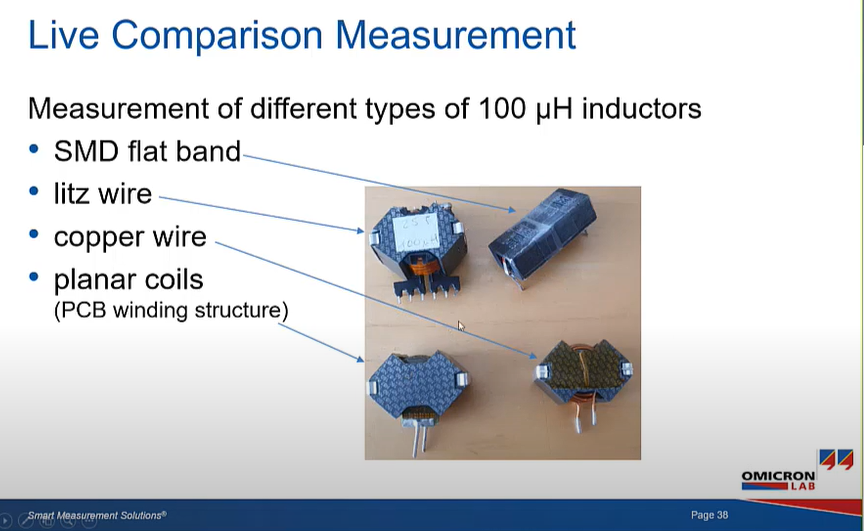

In [10]:
filename_chokes_webinar=r"./TestDataFiles/Inductors_2020-07-27T09_29_28.xlsx"
# df_sirio = pd.read_excel(io=filename_choke, sheet_name=sheetname_choke_sirio)
df_chokes = pd.read_excel(io=filename_chokes_webinar)
df_chokes.columns

Index(['Frequency (Hz)', 'Unnamed: 1', 'FlatBandWire: Frequency (Hz)',
       'FlatBandWire: Trace 1: Magnitude (Ω)',
       'FlatBandWire: Trace 2: Phase (°)', 'Unnamed: 5',
       'PCB LitzEmulation: Frequency (Hz)',
       'PCB LitzEmulation: Trace 1: Magnitude (Ω)',
       'PCB LitzEmulation: Trace 2: Phase (°)', 'Unnamed: 9',
       'RF Litz Wire: Frequency (Hz)', 'RF Litz Wire: Trace 1: Magnitude (Ω)',
       'RF Litz Wire: Trace 2: Phase (°)', 'Unnamed: 13',
       'SolidStrand: Frequency (Hz)', 'SolidStrand: Trace 1: Magnitude (Ω)',
       'SolidStrand: Trace 2: Phase (°)'],
      dtype='object')

In [11]:
f=df_chokes['Frequency (Hz)']
Zabs_flatwire=df_chokes['FlatBandWire: Trace 1: Magnitude (Ω)']
Zdeg_flatwire=df_chokes['FlatBandWire: Trace 2: Phase (°)']

Zabs_planar=df_chokes['PCB LitzEmulation: Trace 1: Magnitude (Ω)']
Zdeg_planar=df_chokes['PCB LitzEmulation: Trace 2: Phase (°)']

Zabs_RFlitz=df_chokes['RF Litz Wire: Trace 1: Magnitude (Ω)']
Zdeg_RFlitz=df_chokes['RF Litz Wire: Trace 2: Phase (°)']

Zabs_SolidStrand=df_chokes['SolidStrand: Trace 1: Magnitude (Ω)']
Zdeg_SolidStrand=df_chokes['SolidStrand: Trace 2: Phase (°)']

In [12]:
newplot=LogLogPlotDualAxisPlotly()
newplot.add_trace(f=f, zabs=Zabs_flatwire, zdeg=Zdeg_flatwire, label="FlatBandWire")
newplot.add_trace(f=f, zabs=Zabs_planar, zdeg=Zdeg_planar, label="LitzEmulation")
newplot.add_trace(f=f, zabs=Zabs_RFlitz, zdeg=Zdeg_RFlitz, label="RF Litz Wire")
newplot.add_trace(f=f, zabs=Zabs_SolidStrand, zdeg=Zdeg_SolidStrand, label="SolidStrand")
newplot.show()

In [18]:
range.xa['Hz'] = f
ya.inputData[0] = Zabs_flatwire
ya.inputData[1] = Zdeg_flatwire

my_model = zfitcli.DoModel()
fit_model = zfitcli.import_module("Models." + "rpcpl")
my_model.do_model_cli(range=range, ya=ya, model=fit_model)

R, 34660.6498988781
C, 3.313537467969372e-12
L, 7.921742782834439e-05
Number of function calls: 105


In [19]:
newplot=LogLogPlotDualAxisPlotly()
newplot.add_trace(f=f, zabs=Zabs_flatwire, zdeg=Zdeg_flatwire, label="FlatBandWire")
newplot.add_trace(f=f, zabs=my_model.ya.modeledData[0], zdeg=my_model.ya.modeledData[1], label="FIT_FlatBandWire")
newplot.show()